Uncomment the cell below if you are in Google Colab

In [ ]:
!pip install netCDF4

     |████████████████████████████████| 4.7MB 7.4MB/s 
     |████████████████████████████████| 317kB 49.7MB/s 


Question 2:
we want to develop suitable baseline models. The simplest baseline for a prediction task  assume that the temperature for
the next 6 hours will be the same as the last observed temperature.
After importing all the libraries that I need, I have opened the file of st.johns tempreture and delete some of the columns that we do not need. By minmaxscaler I have changed data's value between 0 and 1. After spilliting data(80 percent for train and 20 percent for test) with function to-sequences we convert an array of values into a dataset matrix. Seq_size is the number of previous time steps to use as input variables to predict the next time period. Because we are using 5 previous hour to predict hour six. our seq-size is 5.
I have have experimented my neural network model with various hyperparameter by varying the number of hidden layers, units per layer, activation functions, etc.
for Visualizing some of the predictions from the two baseline models and the feedforward NN model, along with the true labels. I have plotted the baseline and predictions.
I have verified the models on the test dataset, using the mean squared error as verification


Shape of training set: (70131, 5)
Shape of test set: (17529, 5)
Build deep model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________
None
(None, 5)
(None, 64)
(None, 32)
Epoch 1/100
2192/2192 - 4s - loss: 0.0023 - acc: 2.8518e-05 - val_loss: 1.5859e-04 - val_acc: 0.0000e+00
Epoch 2/100
2192/2192 - 4s - loss: 2.2052e-04 - acc: 2.8518e-05 - val_loss: 1.4979e-04 - val_acc: 0.0000e+00
Epoch 3/100
2192/2192 - 4s - loss: 2.1447e-04 -

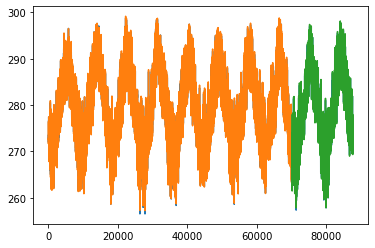

In [ ]:
import netCDF4
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


ds = xr.open_dataset("tempStJohns.nc")
df=ds.to_dataframe()
df.to_csv('tempStJohns.csv')
df = pd.read_csv('tempStJohns.csv')
df = df.drop(['expver', 'latitude', 'longitude'], axis=1)
df = df.set_index('time')
#df = df.t2m
df.dropna(inplace = True)


#Convert pandas dataframe to numpy array
dataset = df.values
dataset = dataset.astype('float32') #COnvert values to float

# Normalization is optional but recommended for neural network as certain 
# activation functions are sensitive to magnitude of numbers. 
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


# We cannot fit the model like we normally do for image processing where we have
#X and Y. We need to transform our data into something that looks like X and Y values.
# This way it can be trained on a sequence rather than indvidual datapoints. 
# Let us convert into n number of columns for X where we feed sequence of numbers
#then the final column as Y where we provide the next number in the sequence as output.
# So let us convert an array of values into a dataset matrix

#seq_size is the number of previous time steps to use as 
#input variables to predict the next time period.

#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

seq_size = 5
# Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

#Compare trainX and dataset. You can see that X= values at t, t+1 and t+2
#whereas Y is the value that follows, t+3 (since our sequence size is 3)

print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

#Input dimensions are... (N x seq_size)
print('Build deep model...')
# create and fit dense model
model = Sequential()
model.add(Dense(64, input_dim=seq_size, activation='relu')) #12
model.add(Dense(32, activation='relu'))  #8
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
print(model.summary()) 


model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)



# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Estimate model performance
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict[:,0]))
print('Train Score: %.2f %' % (trainScore*100))

testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
print('Test Score: %.2f %' % (testScore*100))

# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 8)                 48        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
35066/35066 - 46s - loss: 6.3477e-04 - acc: 2.8518e-05
Epoch 2/200
35066/35066 - 46s - loss: 2.4212e-04 - acc: 2.8518e-05
Epoch 3/200
35066/35066 - 46s - loss: 2.3568e-04 - acc: 2.8518e-05
Epoch 4/200
35066/35066 - 46s - loss: 2.3476e-04 - acc: 2.8518e-05
Epoch 5/200
35066/35066 - 46s - loss: 2.2991e-04 - acc: 2.8518e-05
Epoch 6/200
35066/35066 - 46s - loss: 2.2881e-04 - acc: 2.8518e-05
Epoch 7/200
35066/35066 - 46s - loss: 2.2627e-04 - acc: 2.8518e-05
Epoch 8/200
35066/35066 - 46s - loss: 2.2399e-

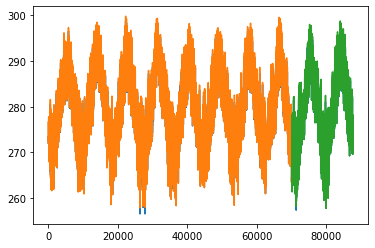

In [ ]:
##################################################
#Try another model....
# create and fit dense model
model = Sequential()
model.add(Dense(8, input_dim=seq_size, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
print(model.summary()) 

model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Estimate model performance
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict[:,0]))
print('Train Score: %.2f %' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
print('Test Score: %.2f %' % (testScore))

# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


Question 1: we want to use a feed forward neural network the classifiying CIFAR images. we have implemented a lstm model to classify images. As CIFAR's output is consist of 10 classes the model's out put is a tensor of 10shapes.
we have splitted the data and by generators we are preprossed the data and then made a prediction. At last I have printed the accuracy.

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
#from keras.utils import to_categorical
import keras.utils.np_utils as nputil
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as metrics

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

def pad(x, pad=4):
    return np.pad(x, ((0,0), (pad,pad),(pad,pad),(0,0)), mode='reflect')

def random_crop(x, random_crop_size = (32,32), sync_seed=None):
    np.random.seed(sync_seed)
    w, h = x.shape[1], x.shape[2]
    rangew = (w - random_crop_size[0]) // 2
    rangeh = (h - random_crop_size[1]) // 2
    offsetw = 0 if rangew == 0 else np.random.randint(rangew)
    offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
    return x[:, offsetw:offsetw+random_crop_size[0], offseth:offseth+random_crop_size[1]]

x_train = pad(x_train)
x_test = pad(x_test)

x_train = x_train.astype('float32')
x_train = (x_train - [125.3, 123.0, 113.9]) / [63.0, 62.1, 66.7]
x_test = x_test.astype('float32')
x_test = (x_test - [125.3, 123.0, 113.9]) / [63.0, 62.1, 66.7]
y_train = nputil.to_categorical(y_train)
y_test = nputil.to_categorical(y_test)

generator = ImageDataGenerator(zca_epsilon=0,
                               horizontal_flip=True,
                               fill_mode='reflect',)

generator.fit(x_train, seed=0, augment=True)

test_generator = ImageDataGenerator(zca_epsilon=0,
                               horizontal_flip=True,
                               fill_mode='reflect',)

test_generator.fit(x_test, seed=0, augment=True)

model=Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(10,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',metrics=['acc'])

model.summary()
for i in range(0, 4):
    print('i = ' + str(i))
    for x_batch, y_batch in generator.flow(x_train, y_train, batch_size=len(x_train)):
        for testx_batch, testy_batch in test_generator.flow(x_test, y_test, batch_size=len(x_test)):
            x_batch = random_crop(x_batch)
            testx_batch = random_crop(testx_batch)
            model.fit(x_batch, y_batch, epochs=1, validation_data=(testx_batch, testy_batch))
            break
        break
yPreds = model.predict(random_crop(x_test))
yPred = np.argmax(yPreds, axis=1)
yPred = nputil.to_categorical(yPred)
yTrue = y_test

accuracy = metrics.accuracy_score(yTrue, yPred) * 100
print("Accuracy : ", accuracy)


170500096/170498071 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               786688    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 805,546
Trainable params: 805,546
Non-trainable params: 0
_________________________________________________________________
i = 0
1563/1563 [==============================] 